# lim.py Demo Notebook

This notebook will seek to introduce important concepts of line intensity mapping cosmology while demonstrating the usage of the lim toolkit.  Most dependent packages can be installed via pip.

In [90]:
import numpy as np # Standard library for scientific python

import astropy.units as u # Astronomy-focused unit-aware programming
import astropy.constants as cu

# Plotting routines
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline
matplotlib.rcParams.update({'lines.linewidth':2})
matplotlib.rcParams.update({'font.size':20})

from copy import deepcopy

# These commands mean that if you import code from a file, that code
# will be reimported if the file is edited
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
# Popular package for cosmology calculations
import camb

In [92]:
# Put parent directory on PATH
import sys
sys.path.append("..")

# Base module for intensity mapping calculations. May give an error
# if dependent packages are not installed
from lim import lim

## Basic Usage

The lim routine by default creates a LineModel object, which is intended to model the observation of one specific line by one specific experiment.  Calling lim without inputs will create an object with the default arguments, which can be found in source/line_model.py and source/line_obs.py.

In [93]:
m = lim()

We can get a full list of the input parameters to the model by calling

In [94]:
m._input_params

{'cosmo_code': 'camb',
 'cosmo_input_camb': {'f_NL': 0,
  'H0': 67.36,
  'cosmomc_theta': None,
  'ombh2': 0.02237,
  'omch2': 0.12,
  'omk': 0.0,
  'neutrino_hierarchy': 'degenerate',
  'num_massive_neutrinos': 3,
  'mnu': 0.06,
  'nnu': 3.046,
  'YHe': None,
  'meffsterile': 0.0,
  'standard_neutrino_neff': 3.046,
  'TCMB': 2.7255,
  'tau': None,
  'deltazrei': None,
  'bbn_predictor': None,
  'theta_H0_range': [10, 100],
  'w': -1.0,
  'wa': 0.0,
  'cs2': 1.0,
  'dark_energy_model': 'ppf',
  'As': 2.1e-09,
  'ns': 0.9649,
  'nrun': 0,
  'nrunrun': 0.0,
  'r': 0.0,
  'nt': None,
  'ntrun': 0.0,
  'pivot_scalar': 0.05,
  'pivot_tensor': 0.05,
  'parameterization': 2,
  'halofit_version': 'mead'},
 'cosmo_input_class': {'f_NL': 0,
  'H0': 67.36,
  'omega_b': 0.02237,
  'omega_cdm': 0.12,
  'A_s': 2.1e-09,
  'n_s': 0.9649,
  'N_ncdm': 3,
  'm_ncdm': '0.2,0.2,0.2',
  'output': 'mPk,mTk'},
 'model_type': 'LF',
 'model_name': 'SchCut',
 'model_par': {'phistar': <Quantity 9.6e-11 1 / (solLu

### Cosmological Model

Let's break that list down a bit. We start with the code to define the background cosmological model.  We can use either camb or class, which are two of the most popular cosmology codes in use.  The first input, cosmo_code, should be either 'camb' or 'class' to select one of these two.  We'll default to camb here.

The second and third inputs define the parameters of the cosmological model, cosmo_input_camb for camb and cosmo_input_class for class.  Only the values which match the selected cosmo_code are used.  If we look at what goes into one of these cosmo_inputs,

In [23]:
m.cosmo_input_camb

{'f_NL': 0,
 'H0': 67.36,
 'cosmomc_theta': None,
 'ombh2': 0.02237,
 'omch2': 0.12,
 'omk': 0.0,
 'neutrino_hierarchy': 'degenerate',
 'num_massive_neutrinos': 3,
 'mnu': 0.06,
 'nnu': 3.046,
 'YHe': None,
 'meffsterile': 0.0,
 'standard_neutrino_neff': 3.046,
 'TCMB': 2.7255,
 'tau': None,
 'deltazrei': None,
 'bbn_predictor': None,
 'theta_H0_range': [10, 100],
 'w': -1.0,
 'wa': 0.0,
 'cs2': 1.0,
 'dark_energy_model': 'ppf',
 'As': 2.1e-09,
 'ns': 0.9649,
 'nrun': 0,
 'nrunrun': 0.0,
 'r': 0.0,
 'nt': None,
 'ntrun': 0.0,
 'pivot_scalar': 0.05,
 'pivot_tensor': 0.05,
 'parameterization': 2,
 'halofit_version': 'mead'}

We see that we can set base LambdaCDM parameters like the Hubble constant H0 and the densities of baryon and dark matter, as well as extensions like f_NL which sets the strength of primordial non-Gaussianity.  For now, we'll leave the cosmology parameters unmodified

### Galaxy Model

The next set of inputs define the core of our line emission model.  The cosmology model given by camb or class defines the large-scale distribution of matter in the universe, the line model describes how galaxies of different luminosities are embedded in that structure.

We therefore need a way to model the distribution of galaxy line luminosities.  We again have to options for how to do this, controlled by the model_type parameter.  If model_type='LF', galaxies are defined by their luminosity function $dn/dL$, which gives the number density of galaxies as a function of their line luminosity.

The model_name and model_par parameters define the specific choice of luminosity function model.  For model_name, we give the name of a function found in the source/luminosity_functions.py file, which takes model_par as an input and outputs $dn/dL$.  Any arbitrary luminosity function can be defined by adding a new function to luminosity_functions.py.

Let's look at our default model_name, the 'SchCut' function.  One of the most common functional forms for $dn/dL$ is the Schechter function
$$
\left.\frac{dn}{dL}\right|_{\rm Sch}=\phi_\ast\left(\frac{L}{L_\ast}\right)^\alpha e^{-L/L_\ast},
$$
which is a simple power law with an exponential cutoff at high luminosity.  Depending on the value of $\alpha$, the Schechter function may diverge at low luminosity, so the 'SchCut' model adds a second exponential cutoff at low luminosity of the form
$$
\left.\frac{dn}{dL}\right|_{\rm SchCut}=\left.\frac{dn}{dL}\right|_{\rm Sch}e^{-L_{\rm min}/L}=\phi_\ast\left(\frac{L}{L_\ast}\right)^\alpha e^{-L/L_\ast-L_{\rm min}/L}
$$

There are four free parameters in thsi model, the overall amplitude $\phi_\ast$, the power law slope $\alpha$, and the high-luminosity cutoff $L_\ast$ from the Schechter function, and the low-luminosity cutoff $L_{\rm min}$.  You can see that default values for these parameters including astropy units are given by the model_par argument

In [24]:
print(m.model_par)

{'phistar': <Quantity 9.6e-11 1 / (solLum Mpc3)>, 'Lstar': <Quantity 2100000. solLum>, 'alpha': -1.87, 'Lmin': <Quantity 5000. solLum>}


We can import the Sch and SchCut functions directly from luminosity_functions.py and compare them

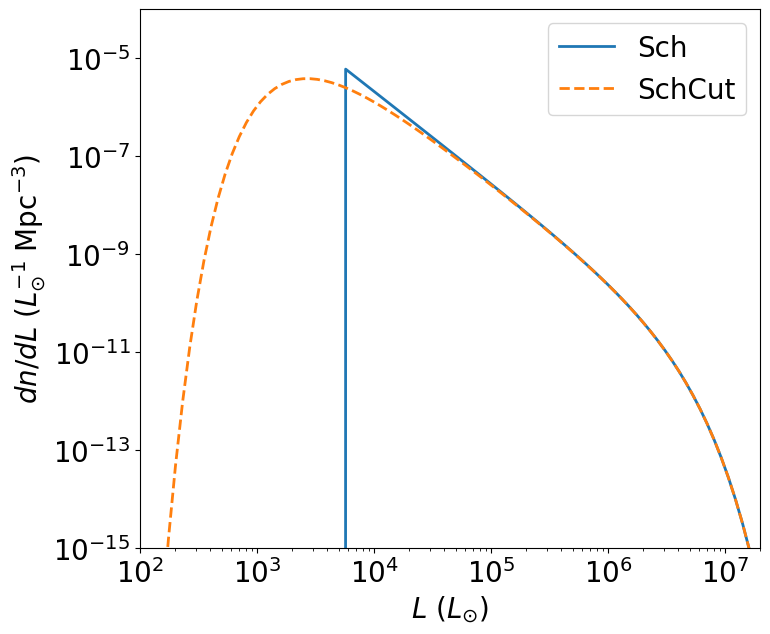

In [42]:
from source.luminosity_functions import Sch, SchCut

# Set vector of luminosities at which to compute dn/dL
L = np.logspace(2,8,100)*u.Lsun # Include astropy units!

dndL_SchCut = SchCut(L,m.model_par)

dndL_Sch = Sch(L,m.model_par) # Note that Sch still uses Lmin, just as a hard cutoff
                              # rather than exponential

fig = plt.figure(figsize=[8,7])

plt.loglog(L,dndL_Sch,label='Sch')
plt.loglog(L,dndL_SchCut,'--',label='SchCut')

ax = plt.gca()
ax.set_ylim(1e-15,1e-4)
ax.set_xlim(1e2,2e7)
ax.set_xlabel('$L$ ($L_{\\odot}$)')
ax.set_ylabel('$dn/dL$ ($L_{\\odot}^{-1}$ Mpc$^{-3}$)')

plt.legend()

# Save axis limits for later
xlim = ax.get_xlim()
ylim = ax.get_ylim()

Note that the two luminosity functions look the same at high luminosity, and have different behavior controlled by Lmin at low luminosity.

We can change the values in model_par to change the luminosity function while preserving the basic shape.

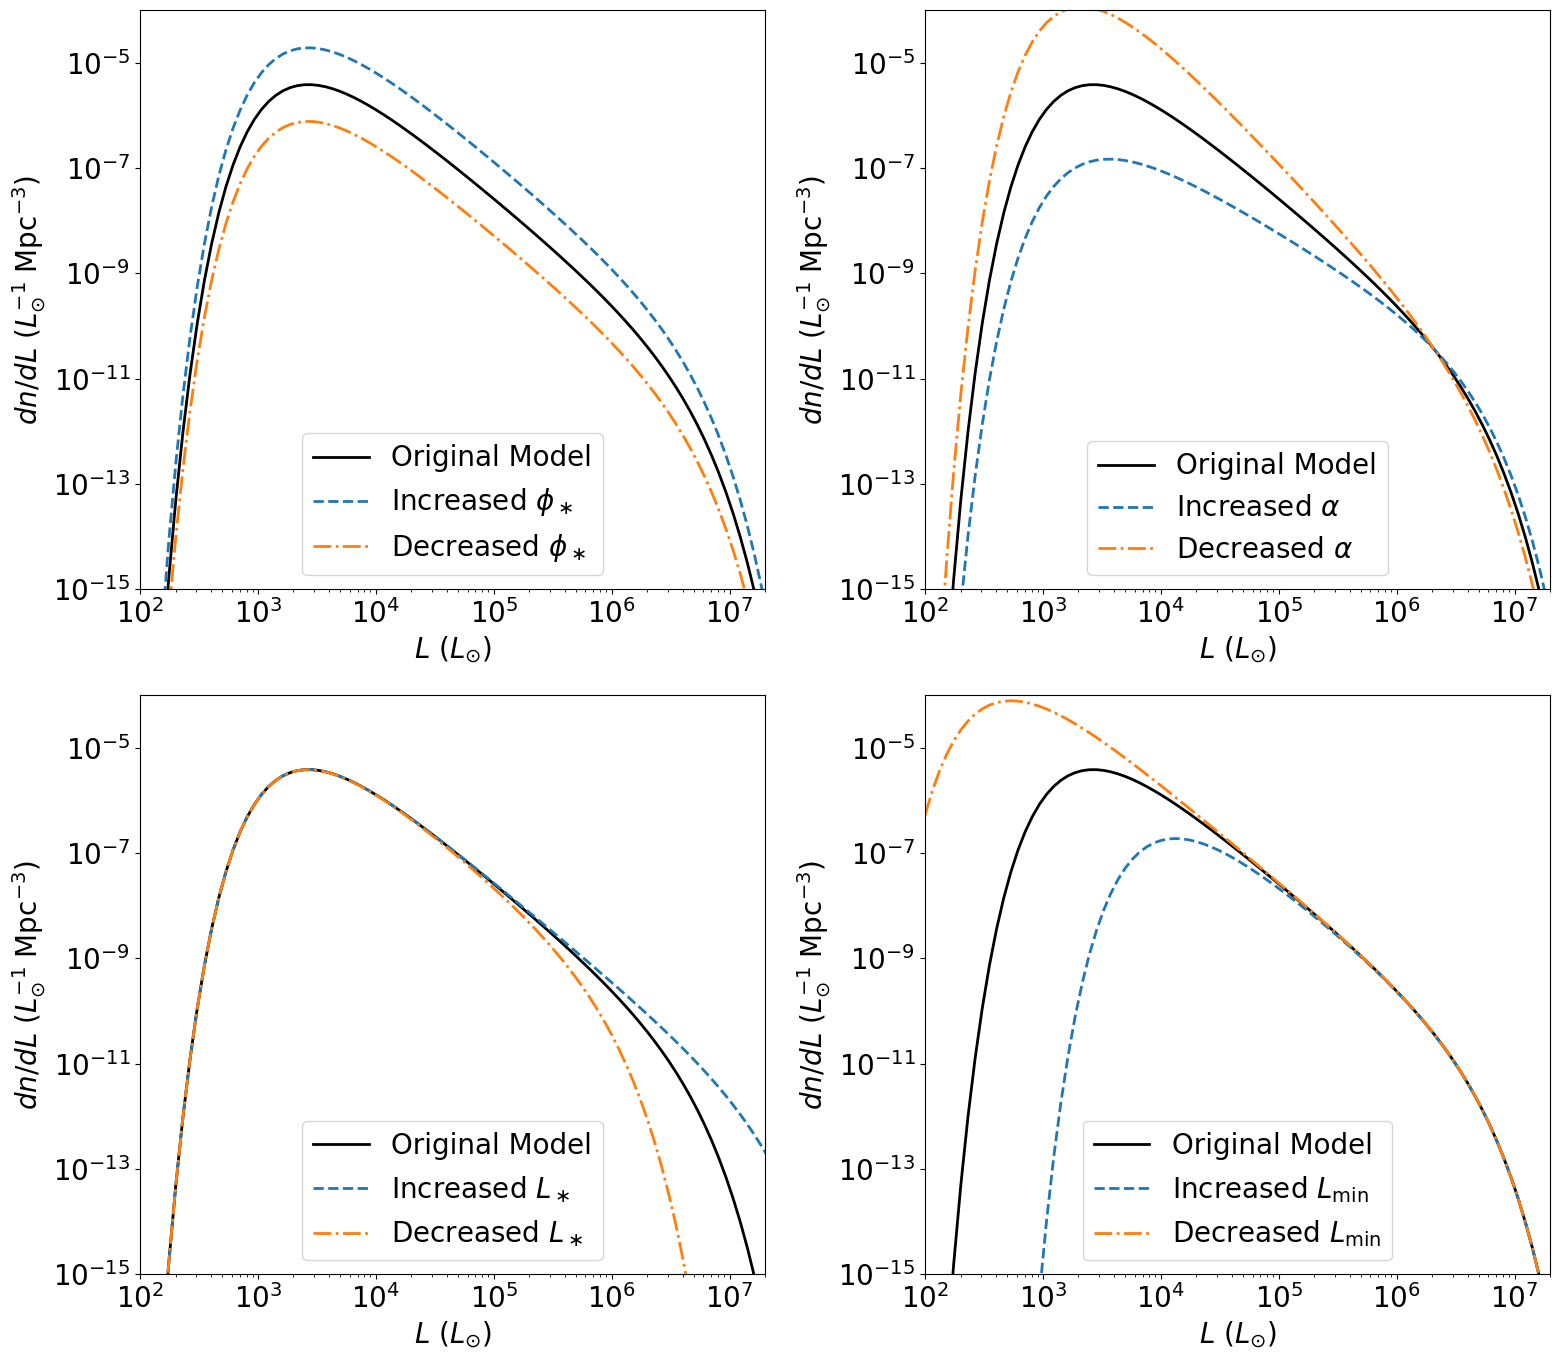

In [57]:
fig = plt.figure(figsize=[16,14])

model_par = deepcopy(m.model_par)

ax = plt.subplot(2,2,1)
# Vary amplitude phistar
model_par['phistar'] = m.model_par['phistar']*5
dndL_phistar_up = SchCut(L,model_par)

model_par['phistar'] = m.model_par['phistar']/5
dndL_phistar_down = SchCut(L,model_par)

model_par['phistar'] = m.model_par['phistar'] # Reset to original value

plt.loglog(L,dndL_SchCut,'k',label='Original Model')
plt.loglog(L,dndL_phistar_up,'--',label='Increased $\\phi_\\ast$')
plt.loglog(L,dndL_phistar_down,'-.',label='Decreased $\\phi_\\ast$')

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.legend()
ax.set_xlabel('$L$ ($L_{\\odot}$)')
ax.set_ylabel('$dn/dL$ ($L_{\\odot}^{-1}$ Mpc$^{-3}$)')



ax = plt.subplot(2,2,2)
# Vary slope alpha
model_par['alpha'] = m.model_par['alpha']+0.5
dndL_alpha_up = SchCut(L,model_par)

model_par['alpha'] = m.model_par['alpha']-0.5
dndL_alpha_down = SchCut(L,model_par)

model_par['alpha'] = m.model_par['alpha'] # Reset to original value

plt.loglog(L,dndL_SchCut,'k',label='Original Model')
plt.loglog(L,dndL_alpha_up,'--',label='Increased $\\alpha$')
plt.loglog(L,dndL_alpha_down,'-.',label='Decreased $\\alpha$')

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.legend()
ax.set_xlabel('$L$ ($L_{\\odot}$)')
ax.set_ylabel('$dn/dL$ ($L_{\\odot}^{-1}$ Mpc$^{-3}$)')




ax = plt.subplot(2,2,3)
# Vary high-L cutoff Lstar
model_par['Lstar'] = m.model_par['Lstar']*5
# Shift phistar as well to isolate cutoff from amplitude shift
model_par['phistar'] = m.model_par['phistar']*5**m.model_par['alpha']
dndL_Lstar_up = SchCut(L,model_par)

model_par['Lstar'] = m.model_par['Lstar']/5
model_par['phistar'] = m.model_par['phistar']*5**-m.model_par['alpha']
dndL_Lstar_down = SchCut(L,model_par)

model_par['Lstar'] = m.model_par['Lstar'] # Reset to original value
model_par['phistar'] = m.model_par['phistar']

plt.loglog(L,dndL_SchCut,'k',label='Original Model')
plt.loglog(L,dndL_Lstar_up,'--',label='Increased $L_\\ast$')
plt.loglog(L,dndL_Lstar_down,'-.',label='Decreased $L_\\ast$')

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.legend()
ax.set_xlabel('$L$ ($L_{\\odot}$)')
ax.set_ylabel('$dn/dL$ ($L_{\\odot}^{-1}$ Mpc$^{-3}$)')





ax = plt.subplot(2,2,4)
# Vary low-L cutoff Lmin
model_par['Lmin'] = m.model_par['Lmin']*5
dndL_Lmin_up = SchCut(L,model_par)

model_par['Lmin'] = m.model_par['Lmin']/5
dndL_Lmin_down = SchCut(L,model_par)

model_par['Lmin'] = m.model_par['Lmin'] # Reset to original value

plt.loglog(L,dndL_SchCut,'k',label='Original Model')
plt.loglog(L,dndL_Lmin_up,'--',label='Increased $L_{\\rm min}$')
plt.loglog(L,dndL_Lmin_down,'-.',label='Decreased $L_{\\rm min}$')

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.legend()
ax.set_xlabel('$L$ ($L_{\\odot}$)')
ax.set_ylabel('$dn/dL$ ($L_{\\odot}^{-1}$ Mpc$^{-3}$)')

plt.tight_layout()

The other way of defining a galaxy model, which we actually tend to use more often these days, is the mass-luminosity relation selected by setting model_type='ML'.  Here, we compute the luminosity of a galaxy $L(M)$ as a function of its mass $M$.

(Formal note: $M$ is assumed to be the mass of the dark matter halo which hosts a galaxy.  Currently lim usually assumes that each dark matter halo hosts exactly one object at its center, with luminosity given by $L(M)$.  Some basic functionality exists to model satellite galaxies, but lim does not currently support full halo occupation distribution models.)

Specific $L(M)$ models are defined similarly to $dn/dL$'s, this time by functions in the source/mass_luminosity.py file.

Text(0, 0.5, '$L(M)$ ($L_{\\odot}$)')

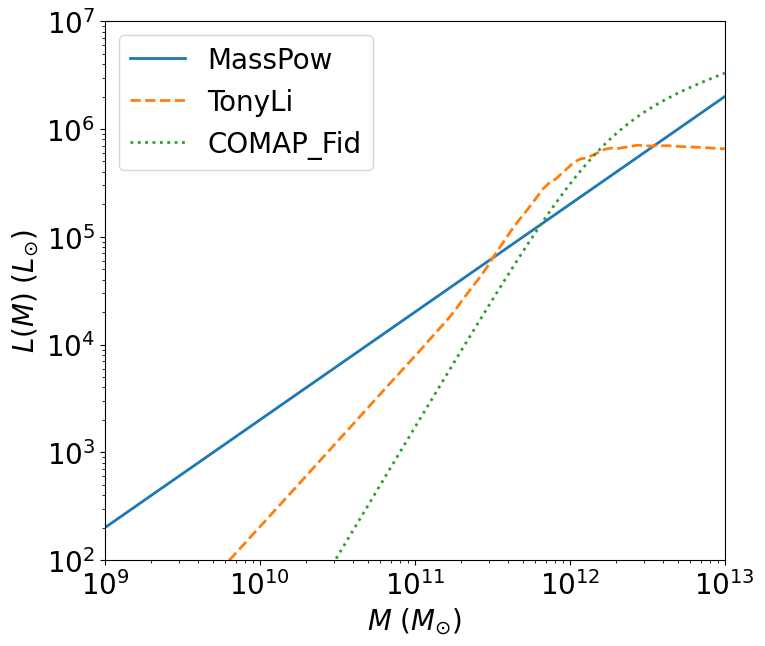

In [85]:
# Some commonly used L(M) 
from source.mass_luminosity import MassPow,TonyLi,COMAP_Fid

M = np.logspace(9,13,100)*u.Msun
z = 3 # Some mass_luminosity functions need to know the redshift
      # We also need to give the lim object m as an argument, as some models
      # pull other information, such as cosmological parameters.

# Simplest model, luminosity is a power law in halo mass
# Parameters based on Pullen et al. 2012
model_par_MassPow = dict(A = 2.0e-7, # Amplitude
                         b = 1) # Slope

LofM_MassPow = MassPow(m,M,model_par_MassPow,z)


# Model based on halo star formation rates, used in Li et al. 2016 and others
model_par_TonyLi = dict(alpha=1.17, # Slope and intercept of CO-FIR power law
                        beta=0.21,
                        dMF=1.0, # Amplitude of SFR-FIR relation
                        SFR_file = '../SFR_tables/sfr_release.dat') # SFR vs. mass table

LofM_TonyLi = TonyLi(m,M,model_par_TonyLi,z)


# Double power law model, currently used as fiducial COMAP model
model_par_COMAP = dict(A = -2.4,
                       B = -0.5,
                       C = 10**10.45,
                       Ms = 10**12.21*u.Msun)

LofM_COMAP = COMAP_Fid(m,M,model_par_COMAP,z)

fig = plt.figure(figsize=[8,7])
plt.loglog(M,LofM_MassPow,label='MassPow')
plt.loglog(M,LofM_TonyLi,'--',label='TonyLi')
plt.loglog(M,LofM_COMAP,':',label='COMAP_Fid')

ax = plt.gca()

ax.set_xlim(1e9,1e13)
ax.set_ylim(1e2,1e7)

ax.legend()

ax.set_xlabel('$M$ ($M_{\\odot}$)')
ax.set_ylabel('$L(M)$ ($L_{\\odot}$)')

Model parameters can be varied in the same way as the $dn/dL$ models.  

One other important detail of the $L(M)$ models is that we can define a scatter around the given relation with the sigma_scatter parameter.  If sigma_scatter=0, all halos with mass $M$ are assumed to host a luminosity of precisely $L(M)$.  If sigma_scatter>0, however, the mean luminosity of halos with mass $M$ is still $L(M)$, but individual galaxies can be brighter or fainter.  Specifically,  log$(L)$ is assumed to be drawn from a Gaussian distribution with mean log$(L(M))$ and standard deviation sigma_scatter.

### Mass Functions

The next two inputs define the mass distribution of dark matter halos.  The parameter hmf_model defines the halo mass function $dn/dM$.  Possible values for hmf_model are names of functions in source/halo_mass_functions.py.

Next, we have the halo bias as a function of mass, given by the parameter bias_model.  Possible values for bias_model are names of functions in source/bias_fitting_functions.py.  A full explanation of the concept of bias is beyond the scope of this tutorial, but basically it describes how halos and galaxies are generally more strongly clustered than dark matter.

Generally, for hmf_model and bias_model we'll usually use 'ST' and 'ST99' or 'Tinker' and 'Tinker08'.  We usually decide based on what calculation or paper we're trying to compare to.

We can plot the actual outputs of the halo mass function and bias using the 'dndM' and 'bofM' methods.

Mass Function:
ST

Bias Model:
ST99


Text(0, 0.5, 'Halo bias $b(M)$ (dimensionless)')

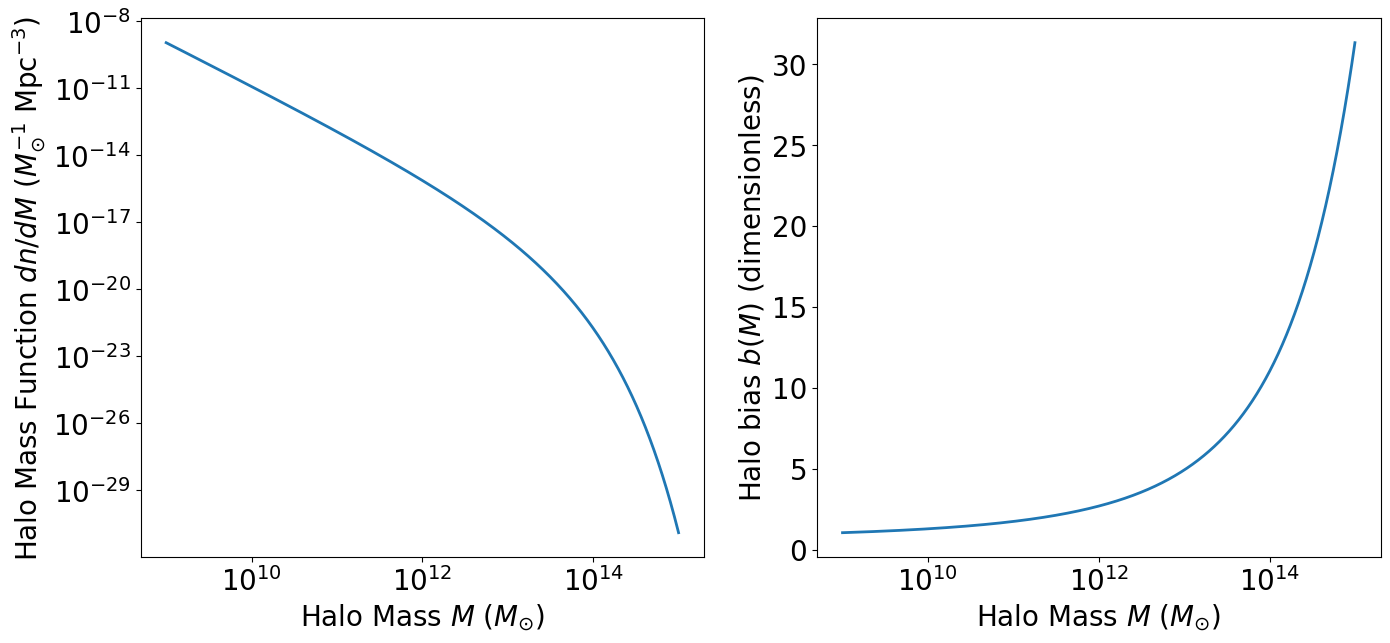

In [119]:
print('Mass Function:')
print(m.hmf_model)
print()
print('Bias Model:')
print(m.bias_model)

fig = plt.figure(figsize=[16,7])

ax = plt.subplot(1,2,1)
plt.loglog(m.M,m.dndM)

ax.set_xlabel('Halo Mass $M$ ($M_{\\odot}$)')
ax.set_ylabel('Halo Mass Function $dn/dM$ ($M_{\\odot}^{-1}$ Mpc$^{-3}$)')


ax = plt.subplot(1,2,2)
plt.semilogx(m.M,m.bofM[:,0]) # Note: The bofM output is tiled several times for ease of
                          # numerical integration, we'll ignore that for now

ax.set_xlabel('Halo Mass $M$ ($M_{\\odot}$)')
ax.set_ylabel('Halo bias $b(M)$ (dimensionless)')


### Frequencies

Next are two of the most straightforward but most important parameters, nu and nuObs, which define the rest frequency of the target line (115 GHz for CO(1-0) by default) and the central observing frequency of the instrument (30 GHz for COMAP by default).  These two parameters define the central redshift of the survey by 
$$
z=\frac{\nu}{\nu_{\rm obs}}-1
$$

Remember that these parameters need to carry appropriate astropy units, or you'll see errors.

In [123]:
print('Rest Frequency:')
print(m.nu)
print()
print('Observed Frequency:')
print(m.nuObs)
print()
print()

print('Computed Redshift:')
print(m.nu/m.nuObs-1)
print()
print('Redshift from lim:')
print(m.z)

Rest Frequency:
115.0 GHz

Observed Frequency:
30.0 GHz


Computed Redshift:
2.8333333333333335

Redshift from lim:
2.8333333333333335


### Units Aside

Brief note on astropy units.  Dimensionful quantities throughout this code need to be given appropriate astropy units.  However, they do not necessarily need to be the exact units given in the input, just an equivalent set of units.

For example, I can give my frequency as 30 GHz or 30000 MHz, and everything will still work.

In [124]:
nu1 = 30*u.GHz
nu2 = 30000*u.MHz

print(nu1==nu2)

True


You can also convert between compatible units using the .to() method

In [125]:
print(nu1)
print(nu2.to(u.GHz))

30.0 GHz
30.0 GHz


The .to() method will throw an error if you try to use it to convert between invalid units, like if we try to convert a frequency to a length.

In [129]:
print(nu1.to(u.cm))

UnitConversionError: 'GHz' (frequency) and 'cm' (length) are not convertible

Using different but compatible units may lead to some odd constructions like

In [126]:
print(nu2/nu1)

1000.0 MHz / GHz


But you can always resolve them using either the .to() method above, or the .decompose() method which reduces all units to their most basic form (usually SI).

In [128]:
print((nu2/nu1).decompose())
print()
print(nu1.decompose())

1.0

30000000000.0 1 / s


For more, see the astropy documentation

In [130]:
m._input_params

{'cosmo_code': 'camb',
 'cosmo_input_camb': {'f_NL': 0,
  'H0': 67.36,
  'cosmomc_theta': None,
  'ombh2': 0.02237,
  'omch2': 0.12,
  'omk': 0.0,
  'neutrino_hierarchy': 'degenerate',
  'num_massive_neutrinos': 3,
  'mnu': 0.06,
  'nnu': 3.046,
  'YHe': None,
  'meffsterile': 0.0,
  'standard_neutrino_neff': 3.046,
  'TCMB': 2.7255,
  'tau': None,
  'deltazrei': None,
  'bbn_predictor': None,
  'theta_H0_range': [10, 100],
  'w': -1.0,
  'wa': 0.0,
  'cs2': 1.0,
  'dark_energy_model': 'ppf',
  'As': 2.1e-09,
  'ns': 0.9649,
  'nrun': 0,
  'nrunrun': 0.0,
  'r': 0.0,
  'nt': None,
  'ntrun': 0.0,
  'pivot_scalar': 0.05,
  'pivot_tensor': 0.05,
  'parameterization': 2,
  'halofit_version': 'mead'},
 'cosmo_input_class': {'f_NL': 0,
  'H0': 67.36,
  'omega_b': 0.02237,
  'omega_cdm': 0.12,
  'A_s': 2.1e-09,
  'n_s': 0.9649,
  'N_ncdm': 3,
  'm_ncdm': '0.2,0.2,0.2',
  'output': 'mPk,mTk'},
 'model_type': 'LF',
 'model_name': 'SchCut',
 'model_par': {'phistar': <Quantity 9.6e-11 1 / (solLu

### Bookkeeping Parameters

The next several inputs are all bookkeeping for mass, luminosity, and the power spectrum wavenumber.  Luminosity-dependent quantities like dndL, mass-dependent quantities like LofM and dndM, and wavenumber-dependent quantities like the power spectrum are all formally continuous functions, but in practice we need to discretize them for computation.

The lim object defines a vector of halo masses 'M', luminosities 'L', and wavenumbers 'k' based on these minima, maxima, and lengths (e.g. Mmin, Mmax, and nM respectively for mass).  Mass and luminosity are always logarithmically spaced, wavenumber can either be linearly or logarithmically spaced depending if k_kind is 'linear' or 'log'.

Usually you can leave these parameters at their defaults.  They would need to be changed if, e.g., your mass-luminosity model needs contributions for halos with masses less than the default $M_{\rm min} = 10^9\ M_{\odot}$, or your instrument is sensitive to scales outside of the given wavenumber range.  

In [135]:
print('Minimum Mass: ')
print(m.Mmin/1e9,m.M.min()/1e9) # Dividing by 1e9 to make it clear that the values match
print()
print('Number of mass bins:')
print(m.nM,len(m.M))

Minimum Mass: 
1.0 solMass 1.0 solMass

Number of mass bins:
5000 5000


### L(M) Scatter

As mentioned above, many mass-luminosity models assume that the given LofM is just the mean luminosity for a given halo mass, and that the actual values can scatter around that value.  The sigma_scatter parameter gives the width of that scatter.

Finally (for now), we have the f_duty parameter.  By default, our models assume that there are $dn/dM$ halos of mass $M$ per unit volume emitting with mean luminosity $L(M)$.  However, there are many situations in reality where not all halos are emitting a line at any given time.  For example, often high-mass halos contain quasars, with powerful winds that dissipate line-emitting gas through a process called feedback.  Assigning a value less than 1 to f_duty means that only that fraction of halos are emmitting the line at any given time.

We'll end our discussion of inputs here for now, we'll come back to the rest later.  

# Cached Properties

This code is intended to be highly modular, so new computations can be added as research projects progress.  We also want it to be fast, so we don't want to waste time recomputing the background cosmology every time we need to change the line emission model.

The way we achieve both of these things is through the cached_property decorator.  If you open up line_model.py, you'll see that after a long init it is made up of constructions like

@cached_property
def function(self):
    '''
    Comment
    '''
    stuff = self.something
    return stuff

@cached_property is a decorator, which is a kind of super-method, where whenever we call m.function() we actually run cached_property(function)).  The definition of cached_property appears in source/tools/_utils.py.  The way it works is that, when a LineModel object is first generated, each method decorated with @cached_property is treated like a function as usual, so when we call m.function it runs the code within the function definition.  However, once the evaluation completes, cached_property replaces the method with it's output.

In other words, if we define a lim() model and ask it for, say, the halo mass function, it takes a moment to calculate because it has to run the full cosmology calculation:

In [141]:
%%time

m = lim()
print(m.dndM)

[1.12266011e-09 1.11653999e-09 1.11054251e-09 ... 1.38787068e-31
 1.33078622e-31 1.27582381e-31] 1 / (solMass Mpc3)
CPU times: user 6.18 s, sys: 37.5 ms, total: 6.22 s
Wall time: 1.03 s


If we call it again, though, 'm.dndM' no longer points to the function to calculate dndM, now it points to the output of that initial run.  So now it can output that value more or less instantly:

In [143]:
%%time
print(m.dndM)

[1.12266011e-09 1.11653999e-09 1.11054251e-09 ... 1.38787068e-31
 1.33078622e-31 1.27582381e-31] 1 / (solMass Mpc3)
CPU times: user 507 μs, sys: 71 μs, total: 578 μs
Wall time: 524 μs


Looking at the basic code block again, we also see the 'self' argument appearing frequently.  This is common in object-oriented python, where self always refers to the parent class.  A cached_property method should always take self as its only argument, and it can use that to get any other information it needs from elsewhere in LineModel.  For example, calculating dndM requires knowing the vector of masses M, which is also a cached_property.  Outside of the code we access it by calling m.M, inside the code we access it by calling self.M.

### Updating

Once consequence of all this is that each method in the class only ever runs once.  If we want to, say, change our model parameters, we need to overwrite that first run and calculate things again.  For this, we have the update() method, which does exactly what it sounds like.  We can run update with the name of any of the input parameters along with the new value we would like it to take.  

For example, a lim() object is generated with a set observed frequency, 30 GHz by default

In [144]:
m = lim() # Original class initiated with default values
print('Original frequency:')
print(m.nuObs)


Original frequency:
30.0 GHz


and redshift is a cached_property computed from that input frequency

In [145]:
print('Original redshift:')
print(m.z)

Original redshift:
2.8333333333333335


Now, if we just try to manually change nuObs, the code has no way to know to recompute the cached properties, and we still get the same redshift

In [146]:
m.nuObs = 15*u.GHz
print('Improperly modified redshift:')
print(m.z)

Improperly modified redshift:
2.8333333333333335


Instead, we use the update() method as follows

In [148]:
m = lim()
print('Original frequency:')
print(m.nuObs)
print('Original redshift:')
print(m.z)
print()

m.update(nuObs=15*u.GHz)
print('Modified frequency:')
print(m.nuObs)
print('Modified redshift:')
print(m.z)
print()

Original frequency:
30.0 GHz
Original redshift:
2.8333333333333335

Modified frequency:
15.0 GHz
Modified redshift:
6.666666666666667



There is also a reset() method, which will update() every input parameter to whatever value they had when the class was first defined (though this doesn't work if you want to substitute class for camb as the cosmo_code or vice versa).

In [150]:
m.reset()
print('Reset frequency:')
print(m.nuObs)
print('Reset redshift:')
print(m.z)
print()

Please, use a new lim() run if you want to use other Boltzmann code
Reset frequency:
30.0 GHz
Reset redshift:
2.8333333333333335



# Intensity Mapping Power Spectra

Now, with all of that out of the way, let's walk through how the power spectrum of a line intensity map is computed.

We'll start by defining input parameters corresponding to a simple line emission model.

In [154]:
par = dict(model_type = 'ML', # Use the simple power law mass-luminosity relation for now
           model_name = 'MassPow',
           model_par = dict(A=2e-6, b=1))
# We'll leave everything else at the defaults for now

m = lim(par) # This is how we initiate a model with something other than default params

### Dark Matter

The first thing we need is the power spectrum of dark matter.  Dark matter dominates the large-scale gravitational dynamics of the Universe, so the locations of galaxies are primarily set by the invisible dark matter density field.

Fortunately, our cosmology codes, camb and class, will straightforwardly compute the dark matter power spectrum for us, without us needing to do the perturbation theory independently.

(Note for experts: we are building a rudimentary halo model here, so we use the linear dark matter spectrum)

Text(0, 0.5, 'DM Power Spectrum $P_m(k)$ (Mpc$^{-3}$)')

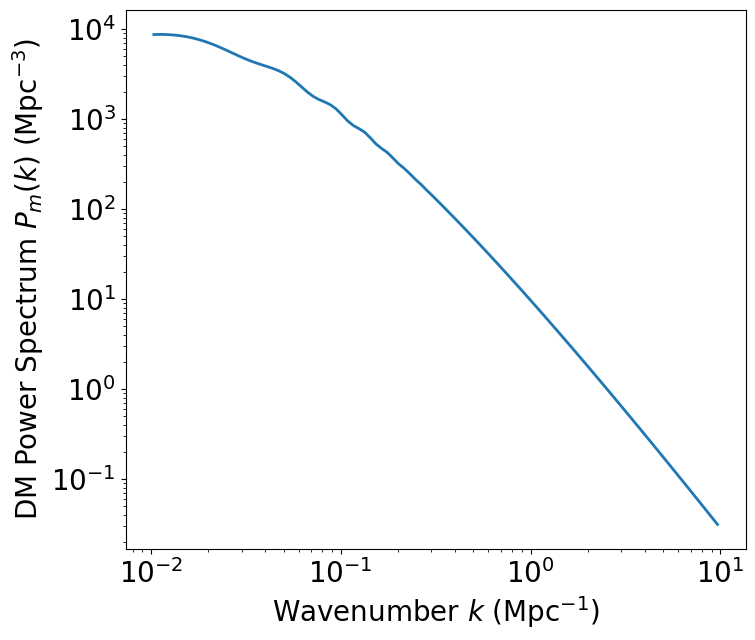

In [163]:
fig = plt.figure(figsize=[8,7])

plt.loglog(m.k,m.Pm[0,:])
# Note that, as with the bias, the actual power spectrum is tiled several times.  This is 
# to account for redshift space distortions later in the calculation, we will ignore it
# for now.  For more detail, see e.g. arXiv:1907.10067

ax = plt.gca()
ax.set_xlabel('Wavenumber $k$ (Mpc$^{-1}$)')
ax.set_ylabel('DM Power Spectrum $P_m(k)$ (Mpc$^{-3}$)')

### Clustering Term

On large scales, the line power spectrum is dominated by the dark matter, but the amplitude is set by the sky-averaged line intensity $\langle T\rangle$ (which we write in brightness temperature units) 
$$
\langle T\rangle = C_{LT}\langle L\rangle,
$$
where $C_{LT}$ is the conversion factor between luminosity and intensity units (given by m.CLT) and
$$
\langle L\rangle = f_{\rm duty}\int L(M)\frac{dn}{dM}dM
$$
is the mean line luminosity set by fduty, LofM, and dndM as described above

In [168]:
print('C_LT$:')
print(m.CLT)
print()
print('Mean Luminosity:')
print(m.Lmean)
print()
print('Mean intensity:')
print(m.Tmean)

C_LT$:
0.0010424413018548563 Mpc3 uK / solLum

Mean Luminosity:
17884.33877777257 solLum / Mpc3

Mean intensity:
18.643373398314527 uK


We can also see how different halo masses contribute to this amplitude by plotting the integrand
$$
L(M)\frac{dn}{dM}
$$


Text(0, 0.5, '$\\langle L\\rangle$ Integrand ($L_{\\odot}$ Mpc$^{-3}$)')

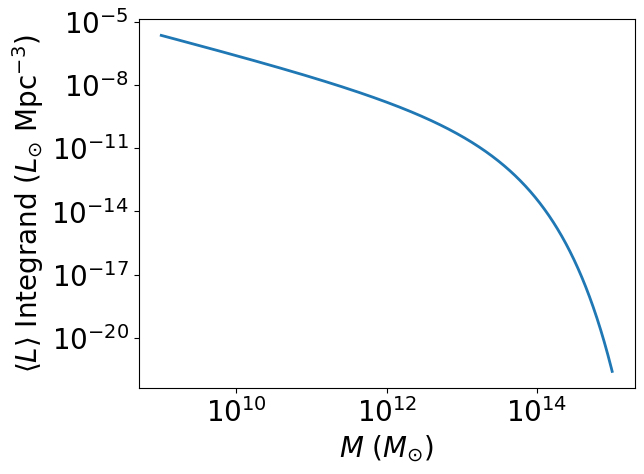

In [172]:
plt.loglog(m.M,m.LofM*m.dndM)

ax = plt.gca()
ax.set_xlabel('$M$ ($M_{\\odot}$)')
ax.set_ylabel('$\\langle L\\rangle$ Integrand ($L_{\\odot}$ Mpc$^{-3}$)')

We also need the luminosity-weighted bias, defined using LofM and bofM as
$$
b = \frac{\int L(M)b(M)dn/dM dM}{\int L(M)dn/dMdM}
$$
and given in the code as bavg.

The full clustering term is then given by
$$
P_{\rm clust}(k) = \langle T\rangle^2 b^2 P_m(k)
$$

Text(0, 0.5, 'Clustering $P(k)$ ($\\mu$K$^2$ Mpc$^3$)')

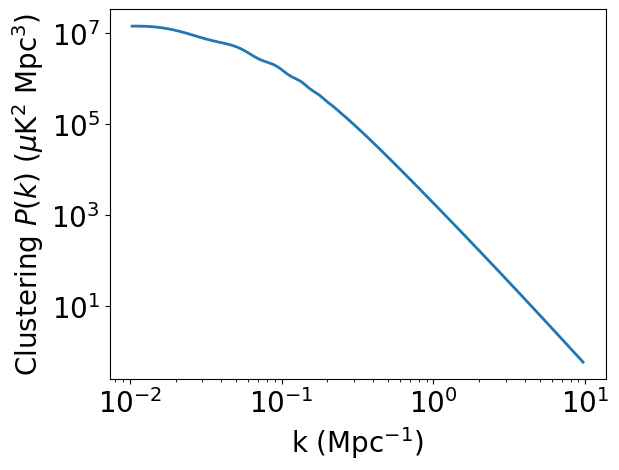

In [178]:
Pclust = 0.5*np.trapezoid(m.Pk_clust,m.mu,axis=0) # Integral to deal with redshift
                                                  # space distortions

plt.loglog(m.k,Pclust)

ax = plt.gca()
ax.set_xlabel('k (Mpc$^{-1}$)')
ax.set_ylabel('Clustering $P(k)$ ($\\mu$K$^2$ Mpc$^3$)')

### Shot noise

The other part of the power spectrum is the shot noise, or the power we would see if dark matter didn't exist and galaxy positions were totally random.  Since random positions don't privilige any particular scale, the shot noise is just a constant, given by
$$
P_{\rm shot} = C_{LT}^2f_{\rm duty}\int L^2(M)\frac{dn}{dM}dM.
$$

Note that sigma_scatter modifies Pshot if it is greater than zero, we'll neglect that for now.

In [179]:
print('Shot noise amplitude:')
print(m.Pshot)

Shot noise amplitude:
29009.949343269298 Mpc3 uK2


We can combine the clustering and shot components to get the full (linear, neglecting redshift space distortions) power spectrum
$$
P(k) = P_{\rm clust}+P_{\rm shot}
$$

Text(0, 0.5, '$P(k)$ ($\\mu$K$^2$ Mpc$^3$)')

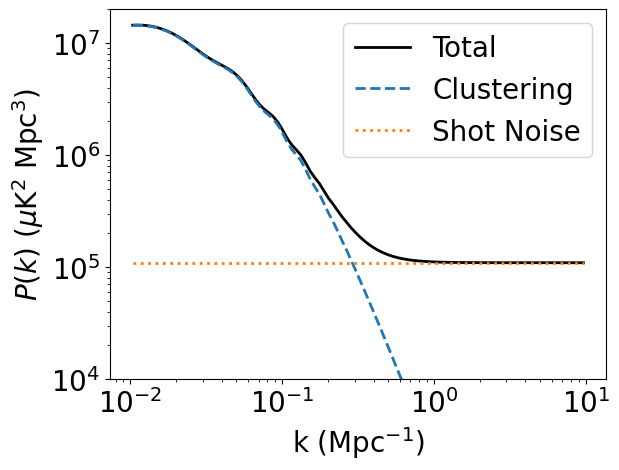

In [192]:
plt.loglog(m.k,m.Pk_0,'k',label='Total')
plt.loglog(m.k,Pclust,'--',label='Clustering')
plt.loglog(m.k,m.Pshot*np.ones(len(m.k)),':',label='Shot Noise')


ax = plt.gca()
ax.set_ylim(1e4,2e7)


plt.legend()
ax = plt.gca()
ax.set_xlabel('k (Mpc$^{-1}$)')
ax.set_ylabel('$P(k)$ ($\\mu$K$^2$ Mpc$^3$)')

You can try update()ing various input parameters to see how the power spectrum changes.

Note: redshifts have been re-sorted (earliest first)
Please, use a new lim() run if you want to use other Boltzmann code


Text(0, 0.5, '$P(k)$ ($\\mu$K$^2$ Mpc$^3$)')

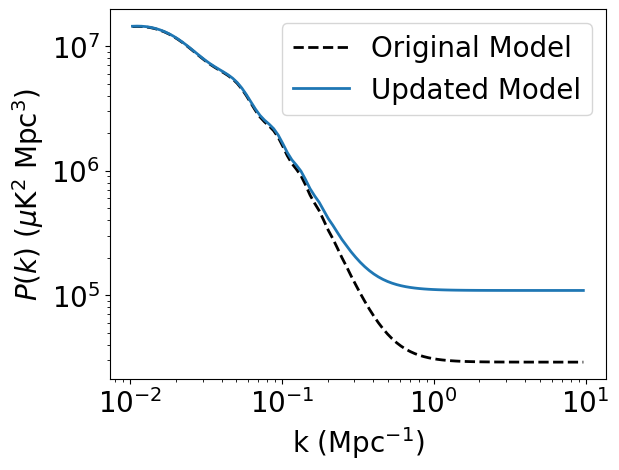

In [195]:
plt.loglog(m.k,m.Pk_0,'k--',label='Original Model')

# Edit this line to update() different parameters.  Remember astropy units!
m.update(sigma_scatter=0.5)
plt.loglog(m.k,m.Pk_0,label='Updated Model')

m.reset()

plt.legend()
ax = plt.gca()
ax.set_xlabel('k (Mpc$^{-1}$)')
ax.set_ylabel('$P(k)$ ($\\mu$K$^2$ Mpc$^3$)')